# Random Forest for ClimateWins

## Table of Contents

#### 1. Importing Libraries and Data
- Loading libraries, weather data, and pleasant weather predictions.

#### 2. Data Wrangling
- Dropping irrelevant columns and handling missing data.

#### 3. Preparing Data
- Aligning features and targets, and splitting into train/test sets.

#### 4. Random Forest Model
- Training and evaluating the Random Forest model.

#### 5. Feature Importances
- Calculating and visualizing feature importances for all weather stations.

#### 6. Top Three Stations Analysis
- Training individual models for `BASEL`, `MAASTRICHT`, and `HEATHROW`.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics  
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing Answers-Weather_Prediction_Pleasant_Weather dataset
answers = pd.read_csv(r"C:\Users\isaac\Documents\CareerFoundry\3. Machine Learning with Python\Basics of ML for Analysis\04 Analysis\Data Sets\01 Raw Data\Answers-Weather_Prediction_Pleasant_Weather.csv")

# Importing Dataset-weather-prediction-dataset-processed dataset
weather = pd.read_csv(r"C:\Users\isaac\Documents\CareerFoundry\3. Machine Learning with Python\Basics of ML for Analysis\04 Analysis\Data Sets\01 Raw Data\Dataset-weather-prediction-dataset-processed.csv")

# Verifying imports
answers.head(), weather.head()

(       DATE  BASEL_pleasant_weather  BELGRADE_pleasant_weather  \
 0  19600101                       0                          0   
 1  19600102                       0                          0   
 2  19600103                       0                          0   
 3  19600104                       0                          0   
 4  19600105                       0                          0   
 
    BUDAPEST_pleasant_weather  DEBILT_pleasant_weather  \
 0                          0                        0   
 1                          0                        0   
 2                          0                        0   
 3                          0                        0   
 4                          0                        0   
 
    DUSSELDORF_pleasant_weather  HEATHROW_pleasant_weather  \
 0                            0                          0   
 1                            0                          0   
 2                            0                          0  

## Data Wrangling

In [4]:
weather = weather.drop([
    # Gdansk
    'GDANSK_cloud_cover', 'GDANSK_humidity', 'GDANSK_precipitation',
    'GDANSK_snow_depth', 'GDANSK_temp_mean', 'GDANSK_temp_min', 'GDANSK_temp_max',
    
    # Rome
    'ROMA_cloud_cover', 'ROMA_wind_speed', 'ROMA_humidity', 'ROMA_pressure',
    'ROMA_sunshine', 'ROMA_temp_mean',
    
    # Tours
    'TOURS_wind_speed', 'TOURS_humidity', 'TOURS_pressure', 'TOURS_global_radiation',
    'TOURS_precipitation', 'TOURS_temp_mean', 'TOURS_temp_min', 'TOURS_temp_max'
], axis=1)
weather.shape

(22950, 149)

### Removing Observation Types Missing in Most Stations

Two observation types are problematic:

- wind_speed (only 9 stations had data)
- now_depth (only 6 stations had data)

Since they are missing for most other stations, drop any columns that end with _wind_speed or _snow_depth:

In [6]:
# Identify columns to drop
columns_to_drop = weather.filter(regex='(_wind_speed|_snow_depth)$').columns
print(columns_to_drop)  # Just to verify

# Drop those columns
weather = weather.drop(columns=columns_to_drop)

Index(['BASEL_wind_speed', 'BASEL_snow_depth', 'DEBILT_wind_speed',
       'DUSSELDORF_wind_speed', 'DUSSELDORF_snow_depth', 'HEATHROW_snow_depth',
       'KASSEL_wind_speed', 'LJUBLJANA_wind_speed', 'MAASTRICHT_wind_speed',
       'MADRID_wind_speed', 'MUNCHENB_snow_depth', 'OSLO_wind_speed',
       'OSLO_snow_depth', 'SONNBLICK_wind_speed', 'VALENTIA_snow_depth'],
      dtype='object')


### Fill 3 Individual Observations from Nearby Stations

Three specific columns were missing:
- KASSEL_cloud_cover (we copied from DUSSELDORF_cloud_cover)
- STOCKHOLM_humidity (we copied from OSLO_humidity)
- MUNCHENB_pressure (we copied from BASEL_pressure)

In [8]:
# locating columns (to figure out where to insert)
weather.columns.get_loc('HEATHROW_temp_max')  
# returns an index so we know where to insert Kassel’s data

# Insert new columns (copying from nearest station)
weather.insert(56, 'KASSEL_cloud_cover', weather['DUSSELDORF_cloud_cover'])
weather.insert(119, 'STOCKHOLM_humidity', weather['OSLO_humidity'])
weather.insert(94, 'MUNCHENB_pressure', weather['BASEL_pressure'])

weather.columns
# Verify they are inserted as expected.

Index(['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity',
       'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation',
       'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min',
       ...
       'STOCKHOLM_temp_max', 'VALENTIA_cloud_cover', 'VALENTIA_humidity',
       'VALENTIA_pressure', 'VALENTIA_global_radiation',
       'VALENTIA_precipitation', 'VALENTIA_sunshine', 'VALENTIA_temp_mean',
       'VALENTIA_temp_min', 'VALENTIA_temp_max'],
      dtype='object', length=137)

---

## Subset to One Decade

In [11]:
#  Subset by decade (2010–2019)

# DATE column is interpretable as a string or an integer for slicing
# For example, if DATE is an integer like 20100101 -> str[:4] = '2010'
weather['DATE'] = weather['DATE'].astype(str)
answers['DATE'] = answers['DATE'].astype(str)

dfdecade_weather = weather[
    (weather['DATE'].str[:4] >= '2010') & (weather['DATE'].str[:4] <= '2019')
].copy()

dfdecade_answers = answers[
    (answers['DATE'].str[:4] >= '2010') & (answers['DATE'].str[:4] <= '2019')
].copy()

print("Subset weather:", dfdecade_weather.shape)
print("Subset answers:", dfdecade_answers.shape)


Subset weather: (3652, 137)
Subset answers: (3652, 16)


## Data Wrangling and Shape Checks on Subset

In [13]:

# Drop columns you don’t need (DATE, MONTH, etc.)
# ---------------------------------------------------------------------
dfdecade_weather.drop(columns=['DATE', 'MONTH'], errors='ignore', inplace=True)

print("Weather shape after dropping unneeded columns:", dfdecade_weather.shape)

# ---------------------------------------------------------------------
# Align answers by dropping DATE 
# ---------------------------------------------------------------------
dfdecade_answers.drop(columns=['DATE'], errors='ignore', inplace=True)

print("Answers shape after dropping unneeded columns:", dfdecade_answers.shape)

#  Final shape checks

print(dfdecade_weather.head(2))
print(dfdecade_answers.head(2))


Weather shape after dropping unneeded columns: (3652, 135)
Answers shape after dropping unneeded columns: (3652, 15)
       BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
18263                  8            0.93          0.9965   
18264                  3            0.74          1.0193   

       BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
18263                    0.18                 0.56             0.0   
18264                    0.58                 0.00             5.2   

       BASEL_temp_mean  BASEL_temp_min  BASEL_temp_max  BELGRADE_cloud_cover  \
18263              2.9            -0.2             4.8                     6   
18264             -1.5            -4.2             0.4                     8   

       ...  STOCKHOLM_temp_max  VALENTIA_cloud_cover  VALENTIA_humidity  \
18263  ...                -7.0                     1               0.80   
18264  ...                -7.1                     1               0.82   

       VALENTIA_pressure

## Prepare 𝑋 and 𝑦

In [15]:
X = dfdecade_weather.values  # or use .to_numpy()
y = dfdecade_answers.values  # shape could be (n_samples, 15) if multi-station

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3652, 135)
y shape: (3652, 15)


## Data Split: Train/Test

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

print("Train/Test shapes:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


Train/Test shapes:
(2739, 135) (2739, 15)
(913, 135) (913, 15)


## Random Forest Model

In [19]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.5914567360350493


### Using `precision_score`, `recall_score`, and `f1_score` from `sklearn.metrics` for further evaluation of model's performance

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train Random Forest Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Weighted for multiclass
recall = recall_score(y_test, y_pred, average='weighted')  # Weighted for multiclass
f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted for multiclass

# Print metrics
print(f"Model Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Evaluate per station if multilabel
for i, station in enumerate(dfdecade_answers.columns):
    station_accuracy = accuracy_score(y_test[:, i], y_pred[:, i])
    station_precision = precision_score(y_test[:, i], y_pred[:, i], average='binary', zero_division=0)
    station_recall = recall_score(y_test[:, i], y_pred[:, i], average='binary', zero_division=0)
    station_f1 = f1_score(y_test[:, i], y_pred[:, i], average='binary', zero_division=0)
    
    print(f"\nStation: {station}")
    print(f"  Accuracy: {station_accuracy:.2f}")
    print(f"  Precision: {station_precision:.2f}")
    print(f"  Recall: {station_recall:.2f}")
    print(f"  F1-Score: {station_f1:.2f}")


Model Accuracy: 0.59
Precision: 0.92
Recall: 0.89
F1-Score: 0.90

Station: BASEL_pleasant_weather
  Accuracy: 0.96
  Precision: 0.94
  Recall: 0.92
  F1-Score: 0.93

Station: BELGRADE_pleasant_weather
  Accuracy: 0.92
  Precision: 0.87
  Recall: 0.92
  F1-Score: 0.89

Station: BUDAPEST_pleasant_weather
  Accuracy: 0.94
  Precision: 0.87
  Recall: 0.96
  F1-Score: 0.91

Station: DEBILT_pleasant_weather
  Accuracy: 0.96
  Precision: 0.95
  Recall: 0.85
  F1-Score: 0.90

Station: DUSSELDORF_pleasant_weather
  Accuracy: 0.96
  Precision: 0.95
  Recall: 0.87
  F1-Score: 0.90

Station: HEATHROW_pleasant_weather
  Accuracy: 0.93
  Precision: 0.91
  Recall: 0.78
  F1-Score: 0.84

Station: KASSEL_pleasant_weather
  Accuracy: 0.96
  Precision: 0.96
  Recall: 0.54
  F1-Score: 0.69

Station: LJUBLJANA_pleasant_weather
  Accuracy: 0.96
  Precision: 0.95
  Recall: 0.92
  F1-Score: 0.93

Station: MAASTRICHT_pleasant_weather
  Accuracy: 0.97
  Precision: 0.94
  Recall: 0.93
  F1-Score: 0.93

Station: 

### Plots Tree

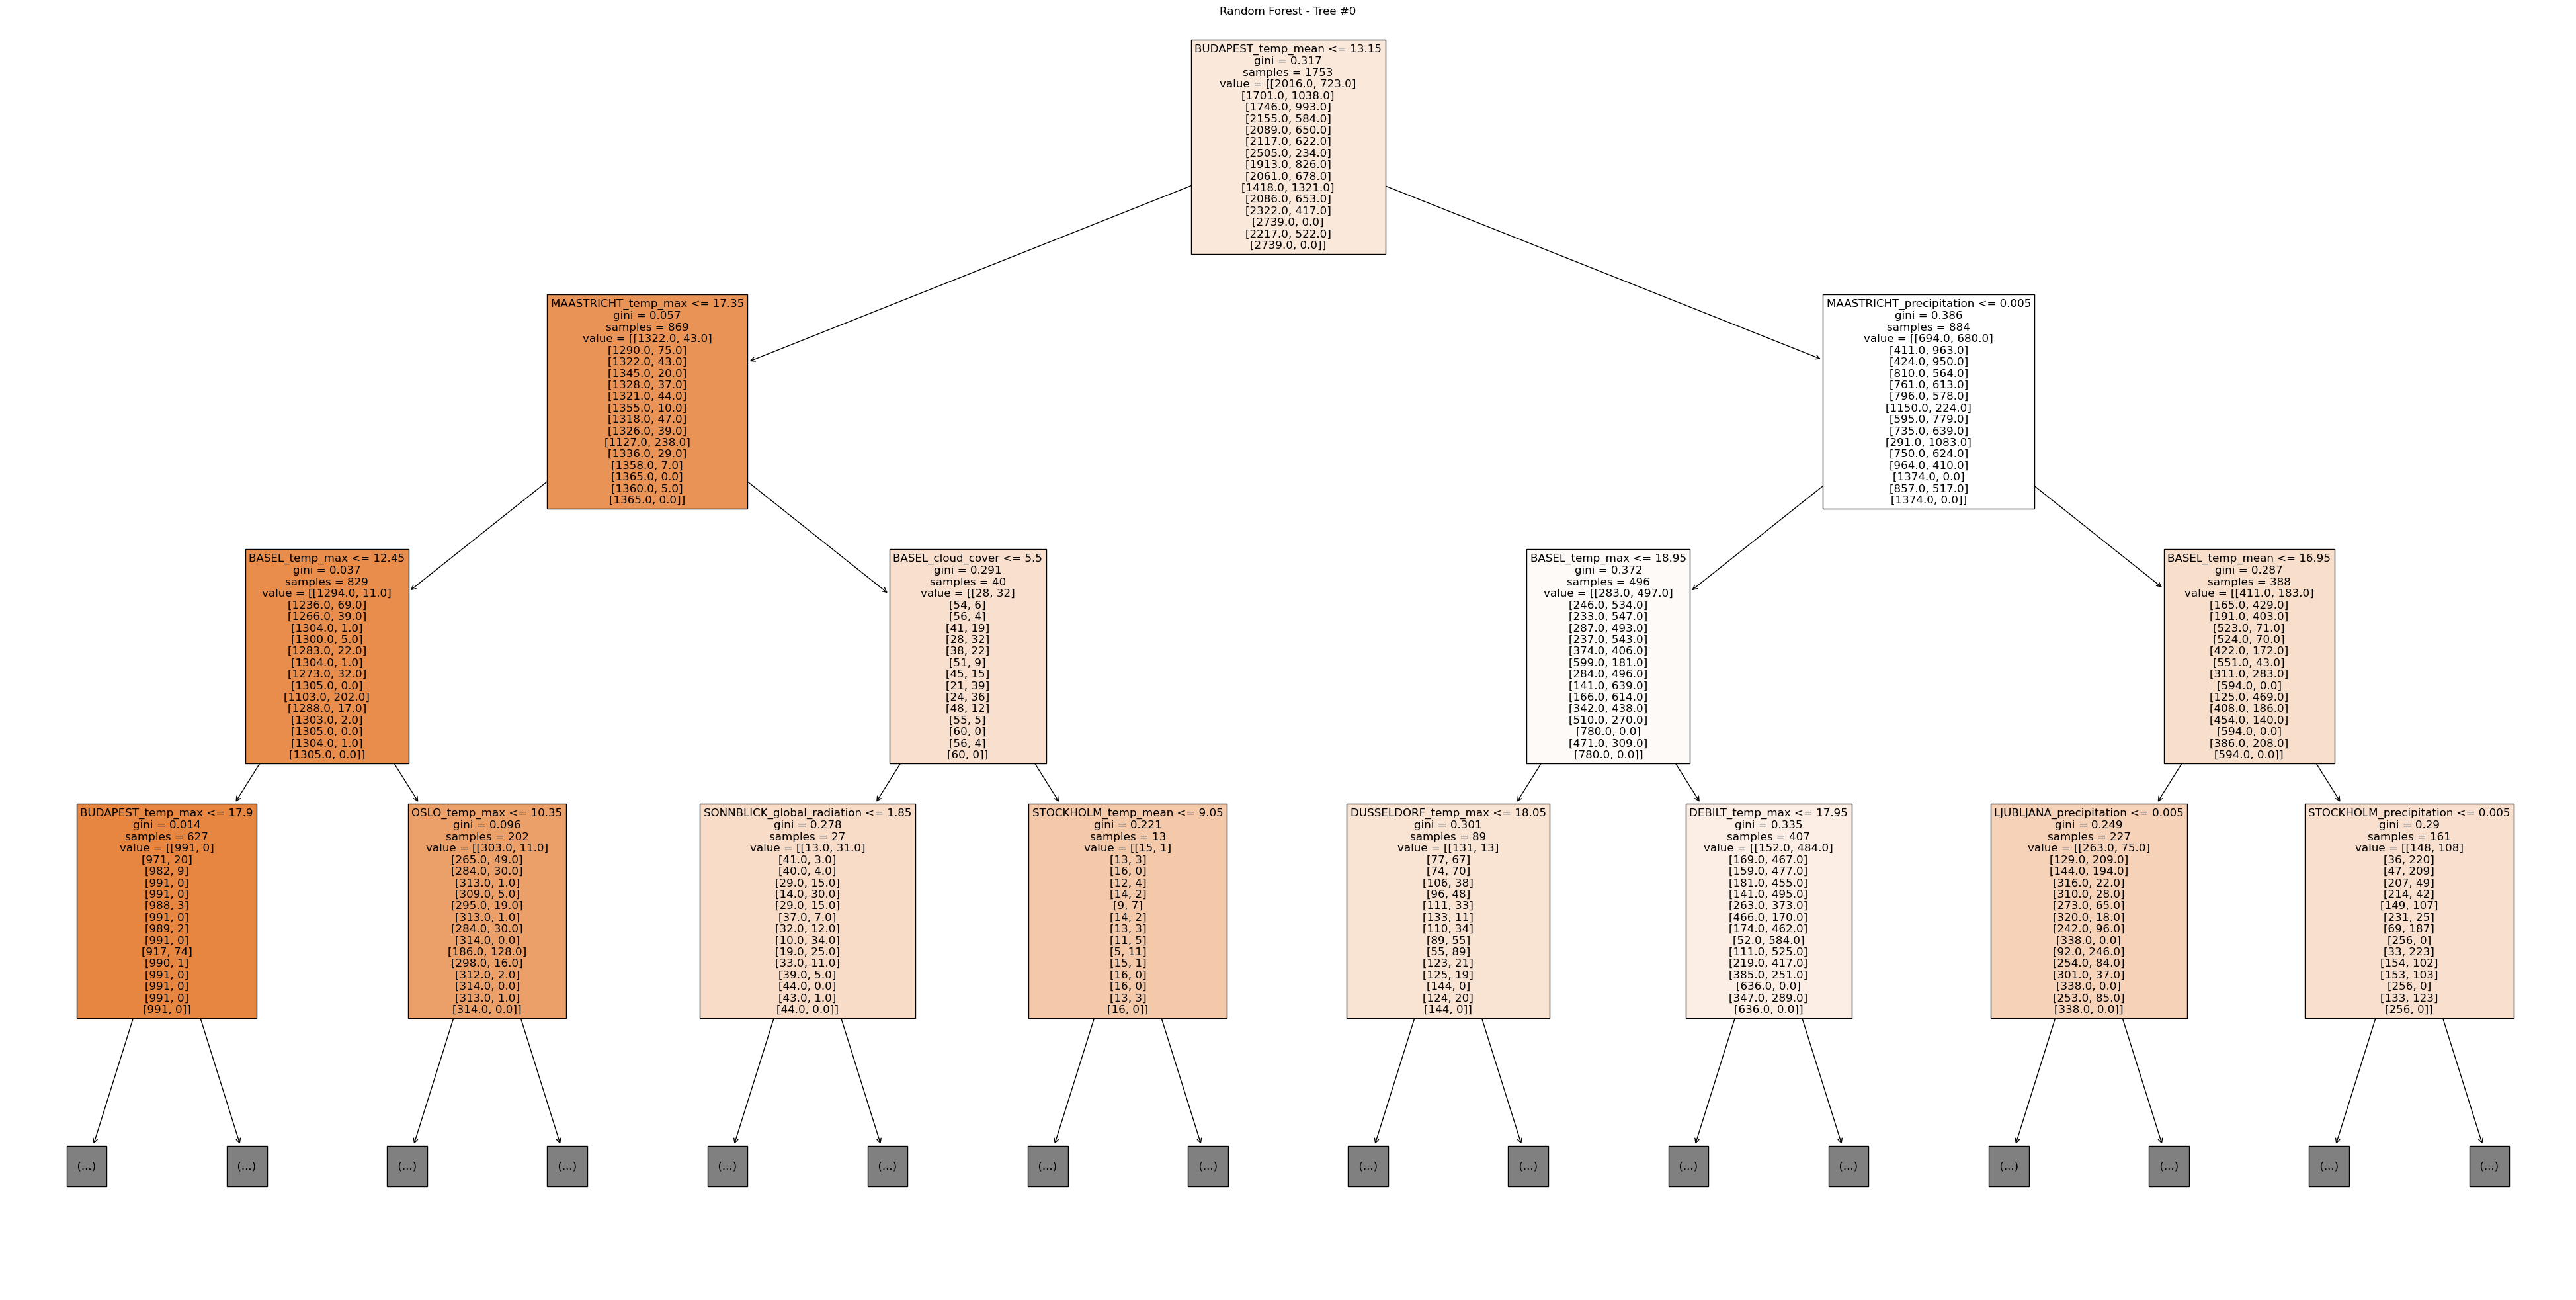

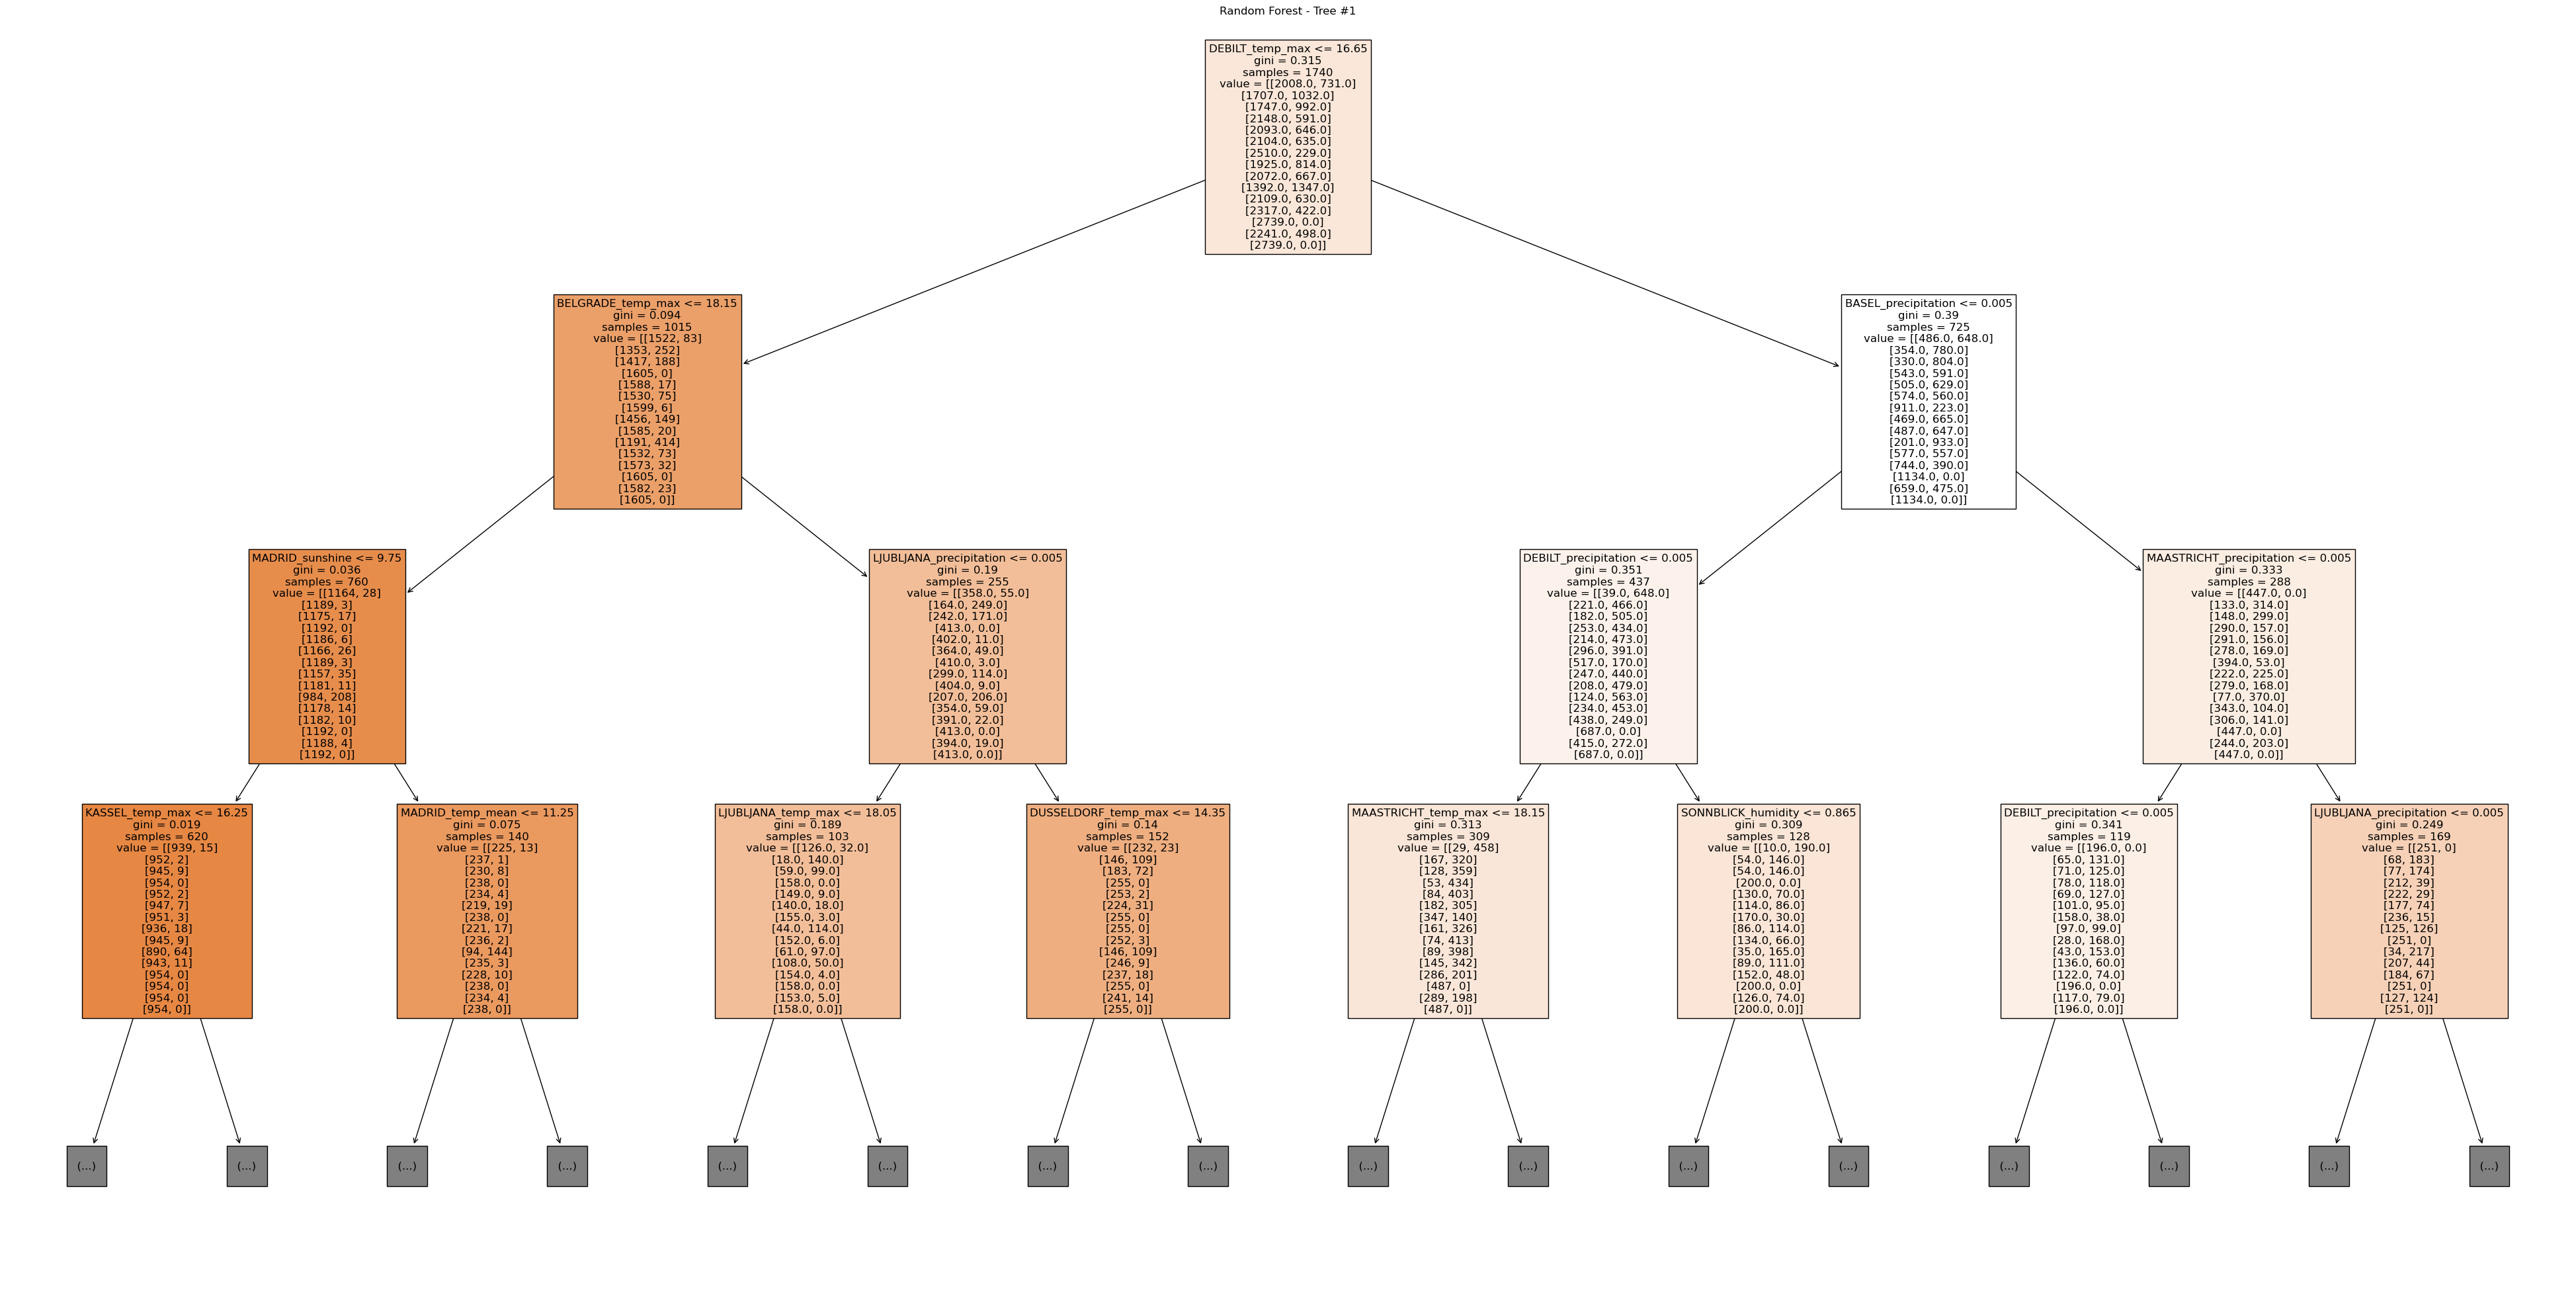

In [21]:
# Plot Tree #1
fig1 = plt.figure(figsize=(50, 25))
plot_tree(clf.estimators_[0], 
          feature_names=dfdecade_weather.columns,
          filled=True, 
          max_depth=3, # just to keep the tree manageable 
          fontsize=12)
plt.title("Random Forest - Tree #0")
plt.show()
fig1.savefig('tree_0.png', bbox_inches='tight')

# Plot Tree #2
fig2 = plt.figure(figsize=(50, 25))
plot_tree(clf.estimators_[1], 
          feature_names=dfdecade_weather.columns,
          filled=True, 
          max_depth=3, 
          fontsize=12)
plt.title("Random Forest - Tree #1")
plt.show()
fig2.savefig('tree_1.png', bbox_inches='tight')

---

## Feature Importances (Multi-Station Scenario)

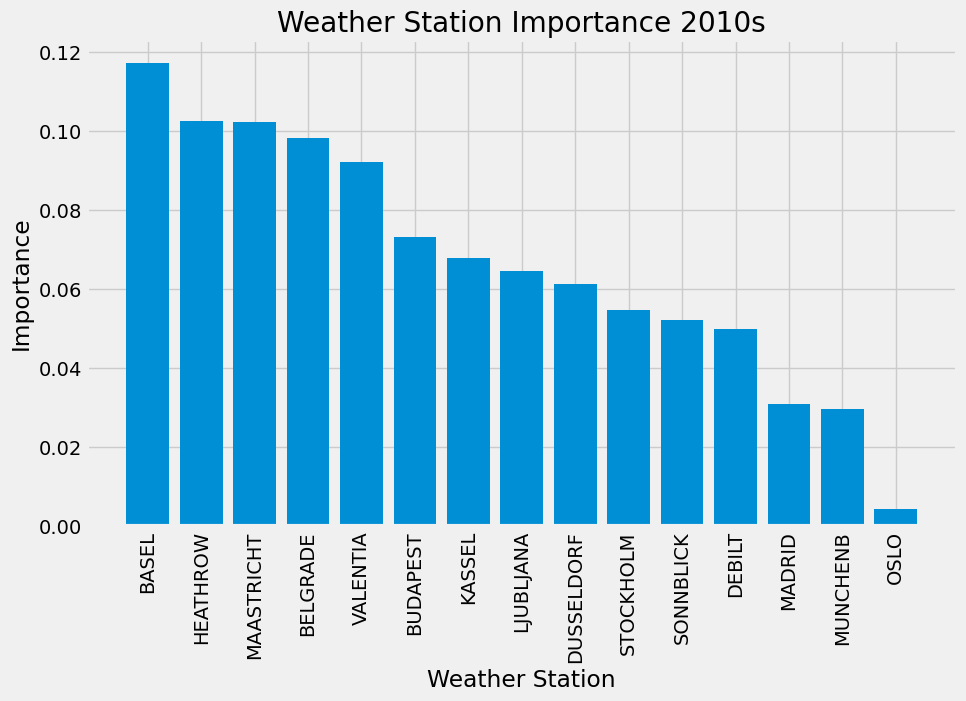

   Weather Station  Importance
8            BASEL    0.117191
4         HEATHROW    0.102414
0       MAASTRICHT    0.102166
10        BELGRADE    0.098207
7         VALENTIA    0.092134
3         BUDAPEST    0.073148
9           KASSEL    0.067896
5        LJUBLJANA    0.064604
2       DUSSELDORF    0.061169
1        STOCKHOLM    0.054679
13       SONNBLICK    0.052065
11          DEBILT    0.049865
12          MADRID    0.030701
6         MUNCHENB    0.029478
14            OSLO    0.004283


In [24]:
# clf is a trained model
newarray = clf.feature_importances_

# Reshape feature importances for weather stations (replace -1, 15, 9 with appropriate dimensions)
newarray = newarray.reshape(-1, 15, 9)

# Collapse this shape into one observation for each weather station
sumarray = np.sum(newarray[0], axis=1)

# List of weather stations (ensure it's aligned with the model's features)
unique_stations_list = [
    'MAASTRICHT', 'STOCKHOLM', 'DUSSELDORF', 'BUDAPEST', 'HEATHROW',
    'LJUBLJANA', 'MUNCHENB', 'VALENTIA', 'BASEL', 'KASSEL', 'BELGRADE',
    'DEBILT', 'MADRID', 'SONNBLICK', 'OSLO'
]

# Create a DataFrame to associate weather stations with their importances
df_importance = pd.DataFrame({
    'Weather Station': unique_stations_list,
    'Importance': sumarray
}).sort_values(by='Importance', ascending=False)

# Plot the results
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 6))
plt.bar(df_importance['Weather Station'], df_importance['Importance'], orientation='vertical')
plt.xticks(rotation='vertical')
plt.xlabel('Weather Station')
plt.ylabel('Importance')
plt.title('Weather Station Importance 2010s')

# Define output path
output_path = r'C:\Users\isaac\Documents\CareerFoundry\3. Machine Learning with Python\Real-World Applications of ML\04 Visualizations'
os.makedirs(output_path, exist_ok=True)

# Save the plot
plt.savefig(os.path.join(output_path, '2010s_feature_importances.png'), bbox_inches='tight')

# Show the plot
plt.show()

# Display the DataFrame for reference
print(df_importance)

---


## Subsetting to the Top Three Stations

Model for BASEL Accuracy: 1.0


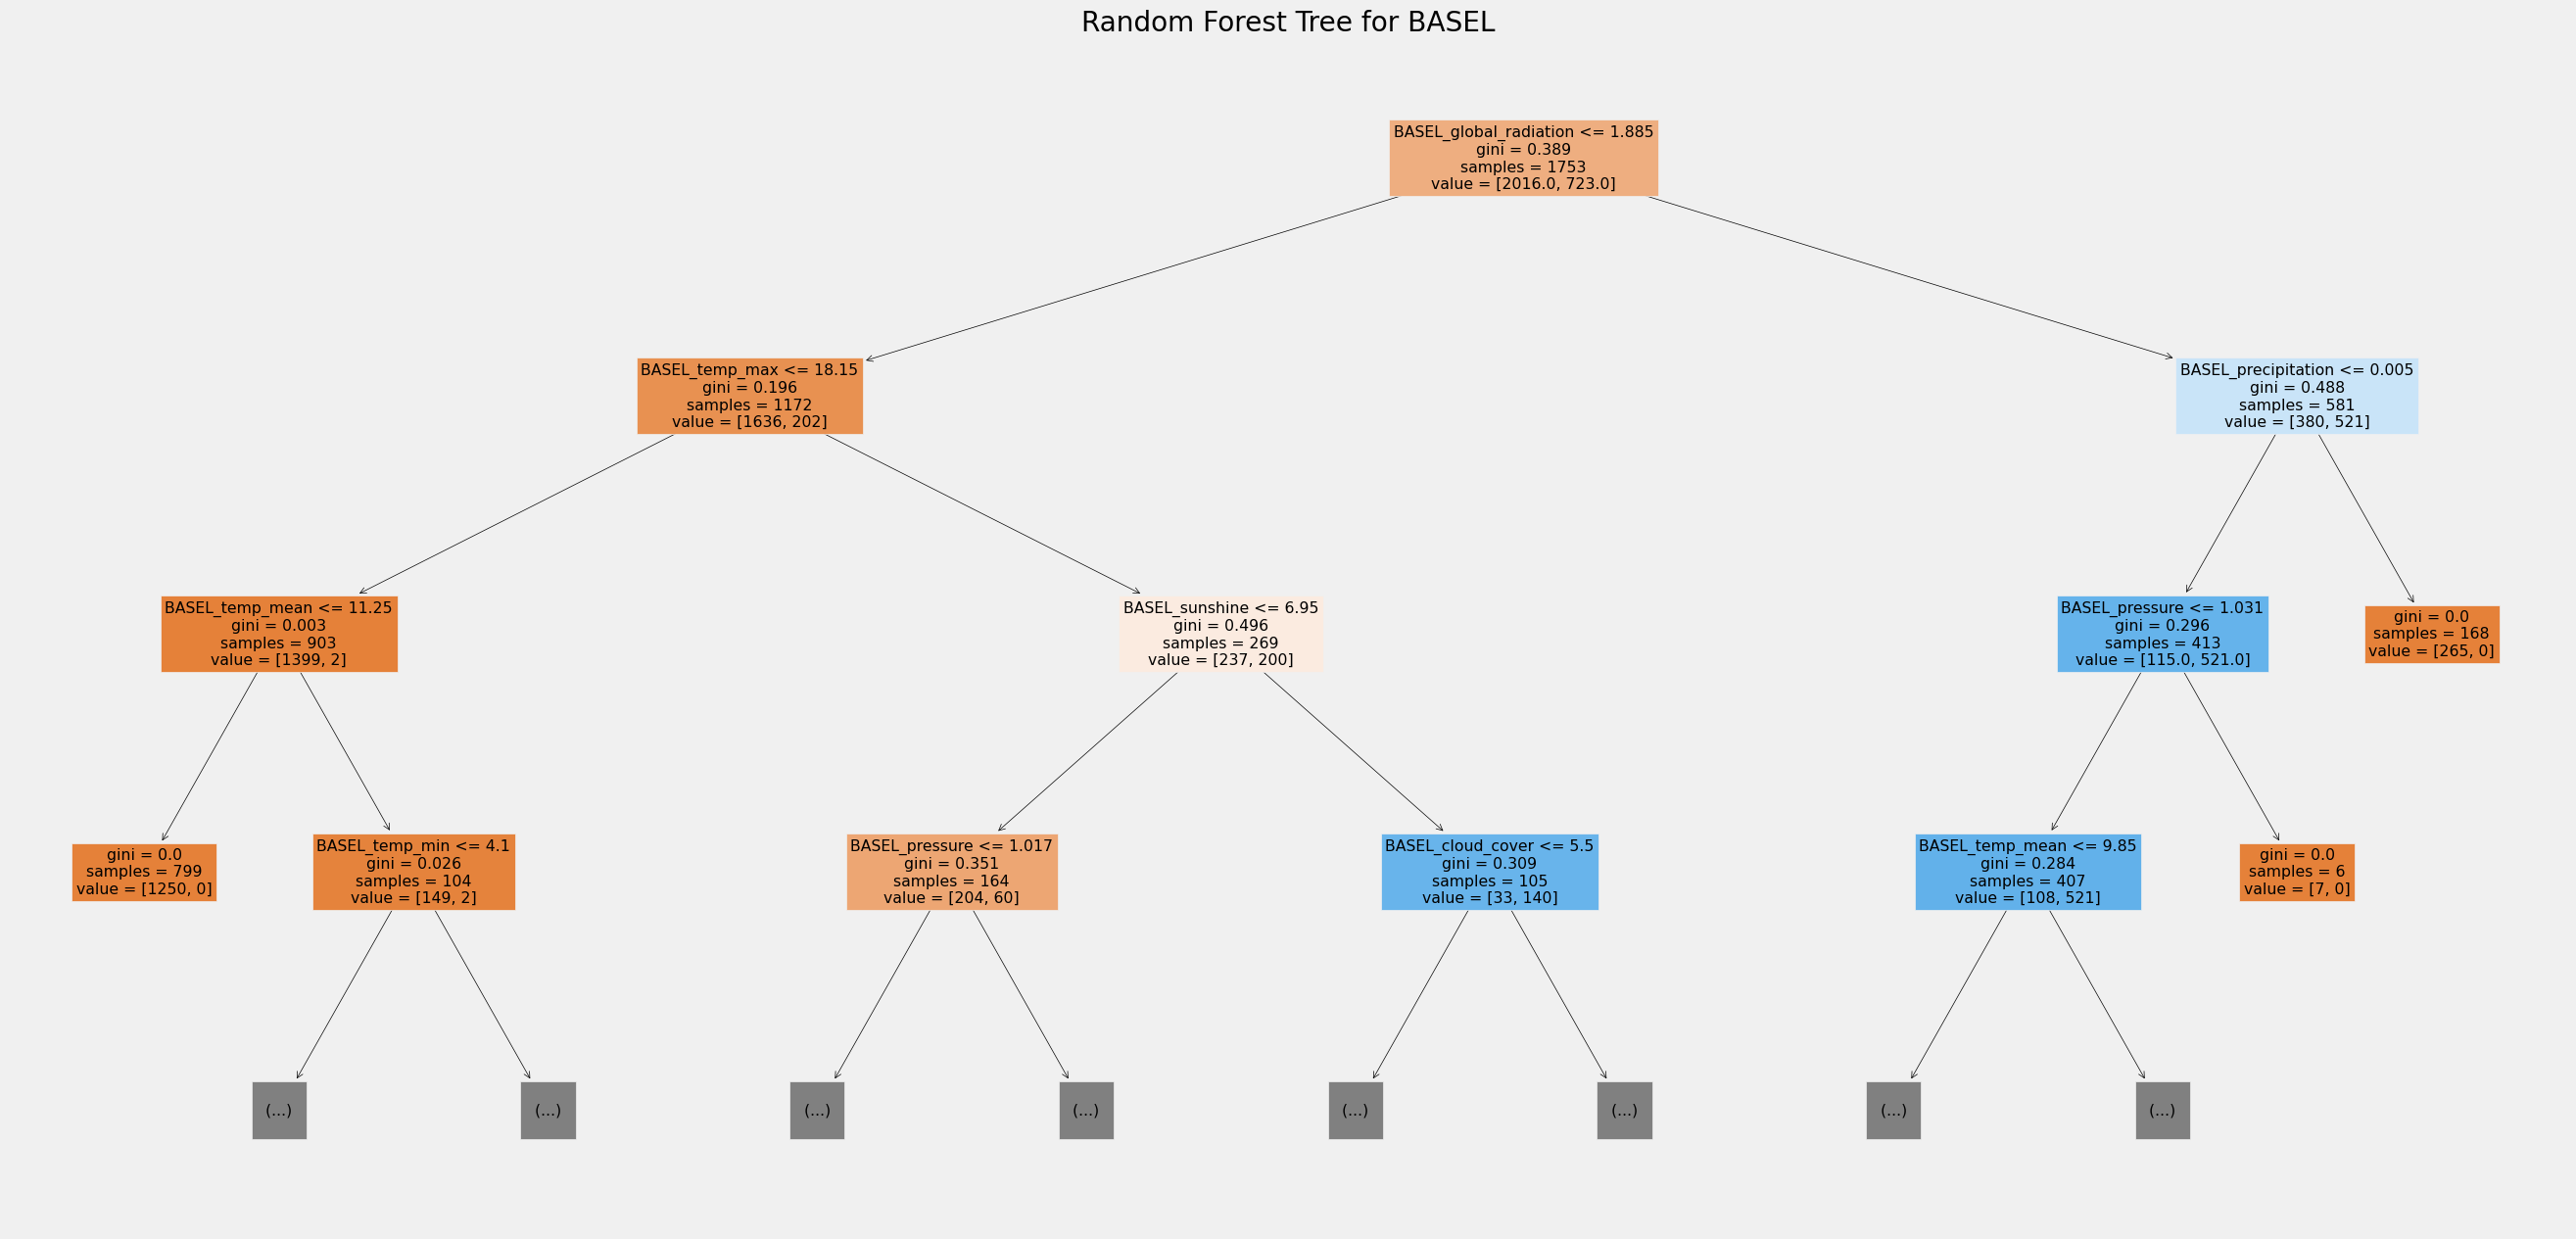

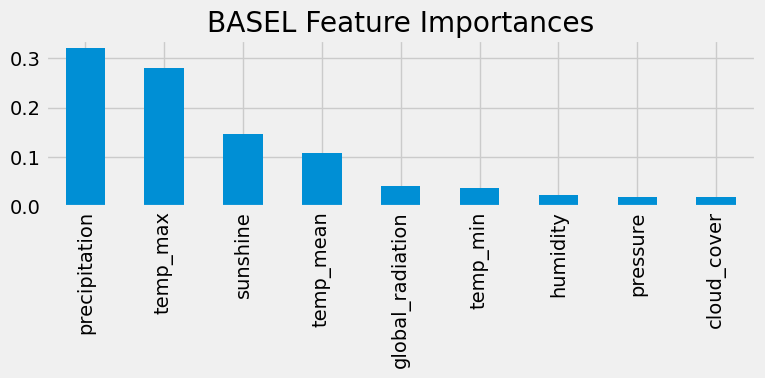

Model for MAASTRICHT Accuracy: 1.0


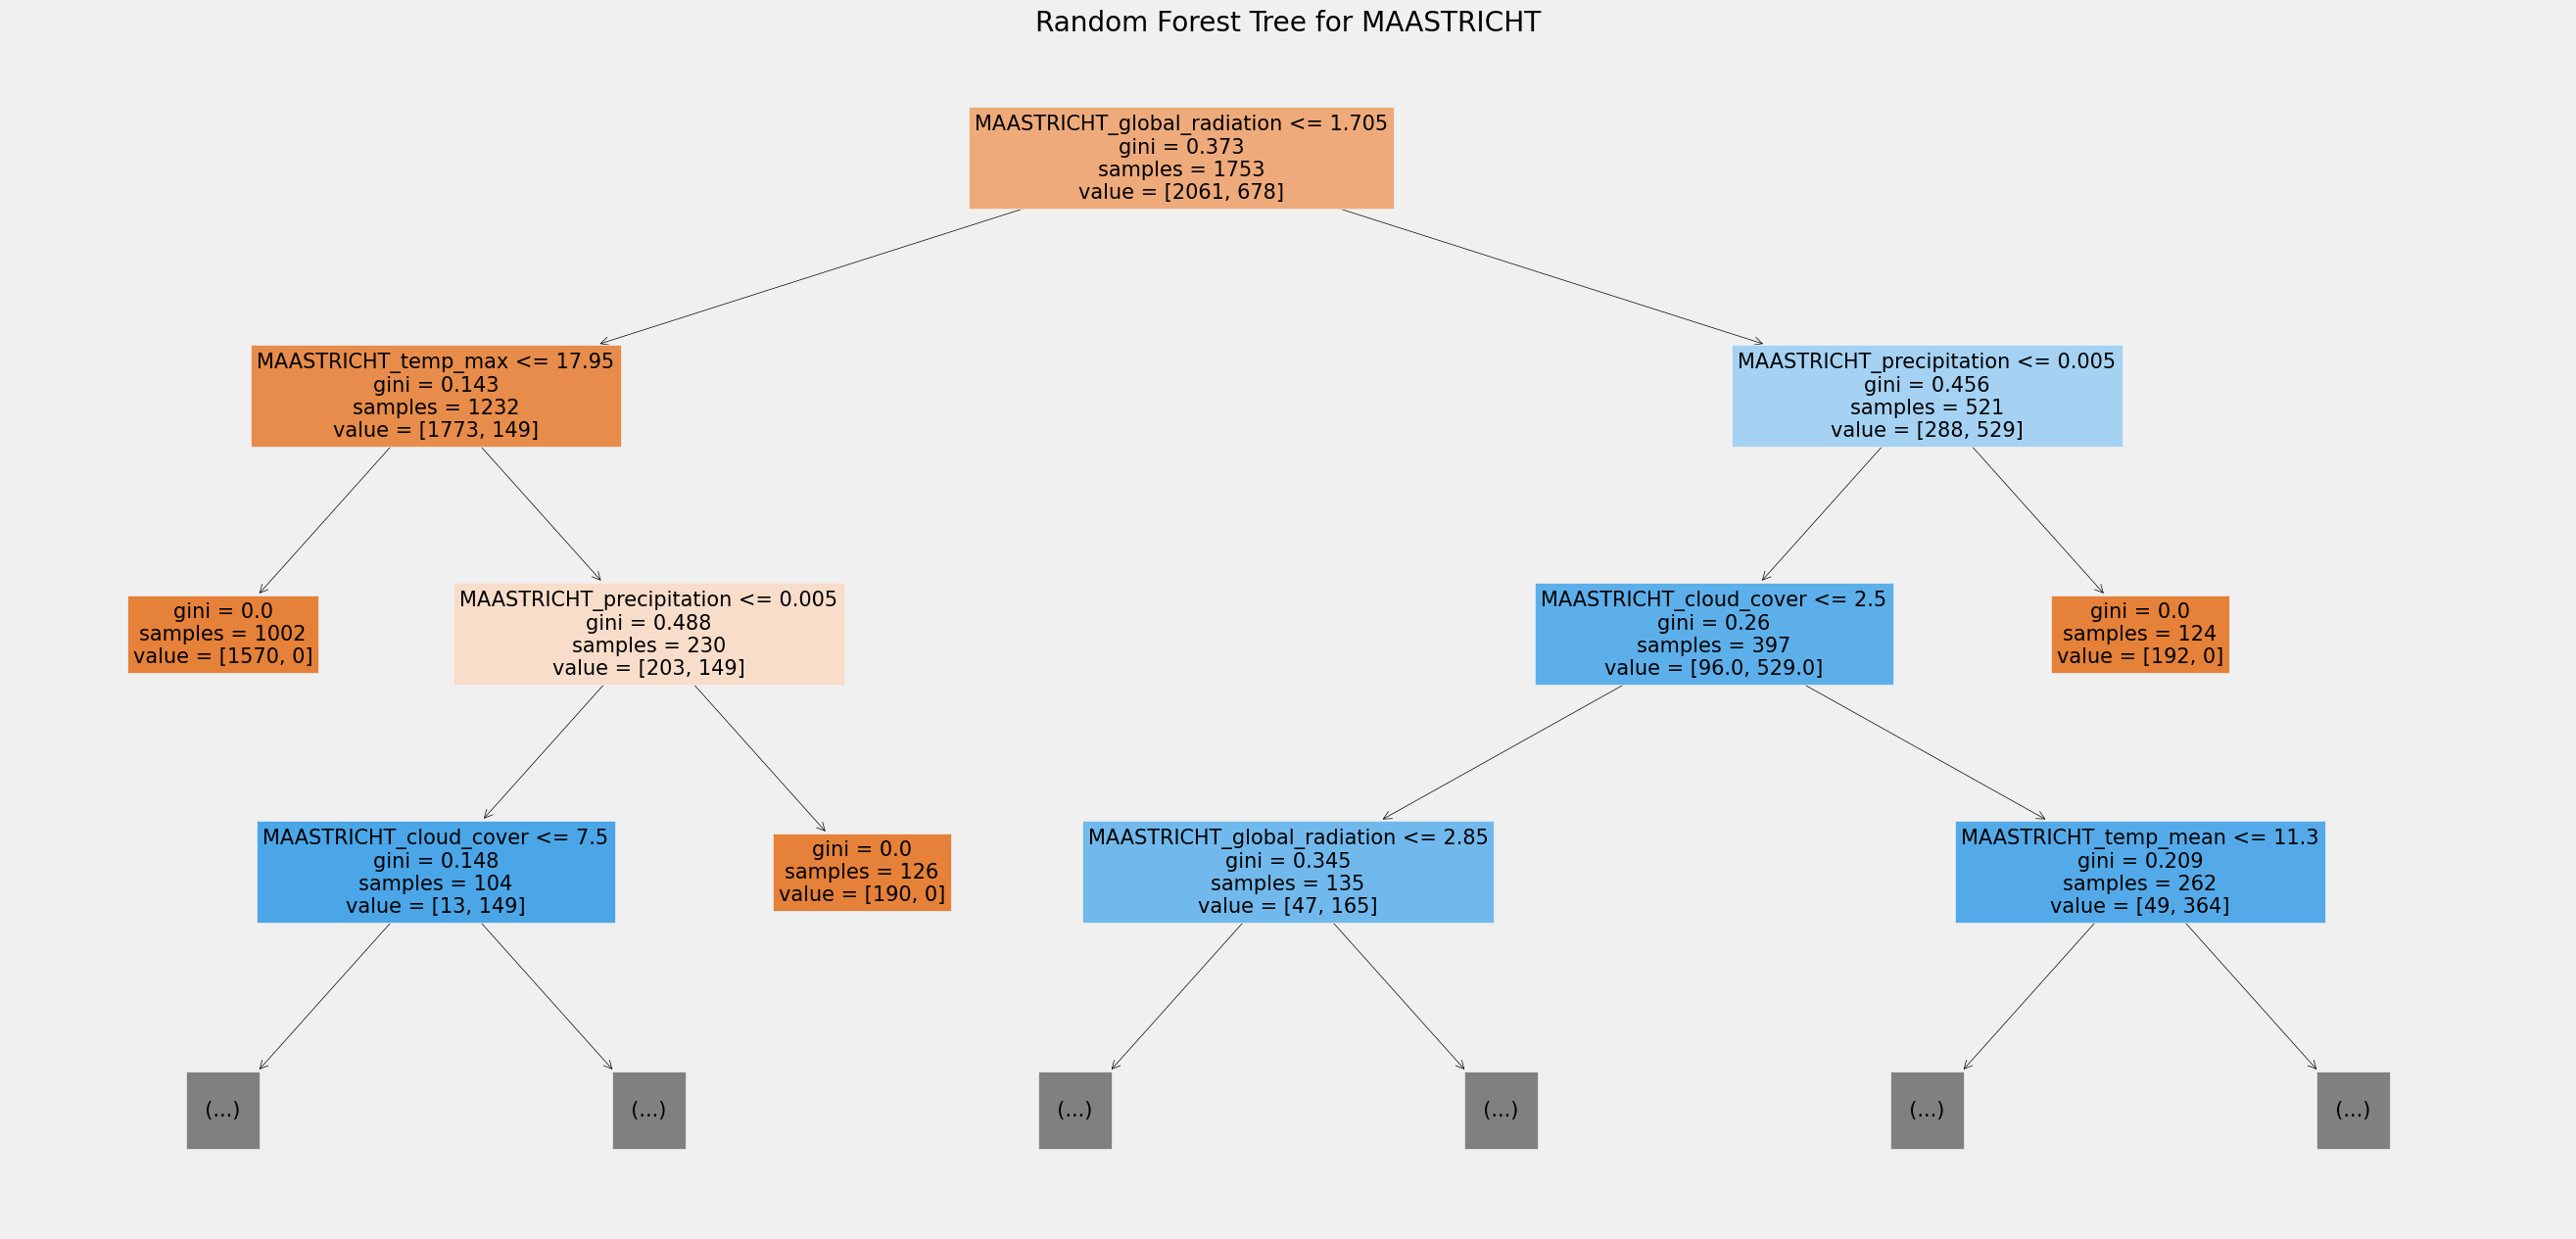

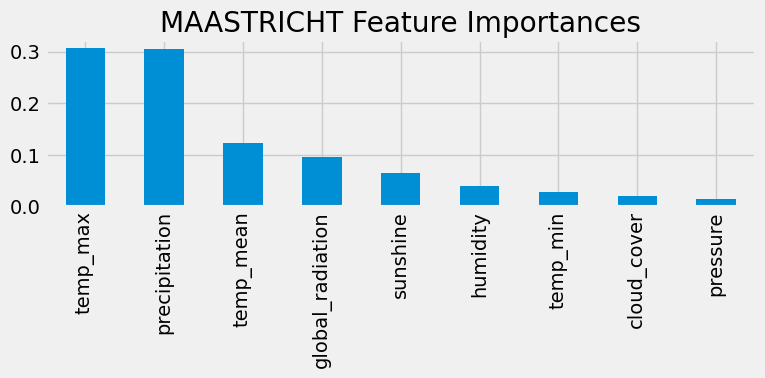

Model for HEATHROW Accuracy: 0.9989047097480832


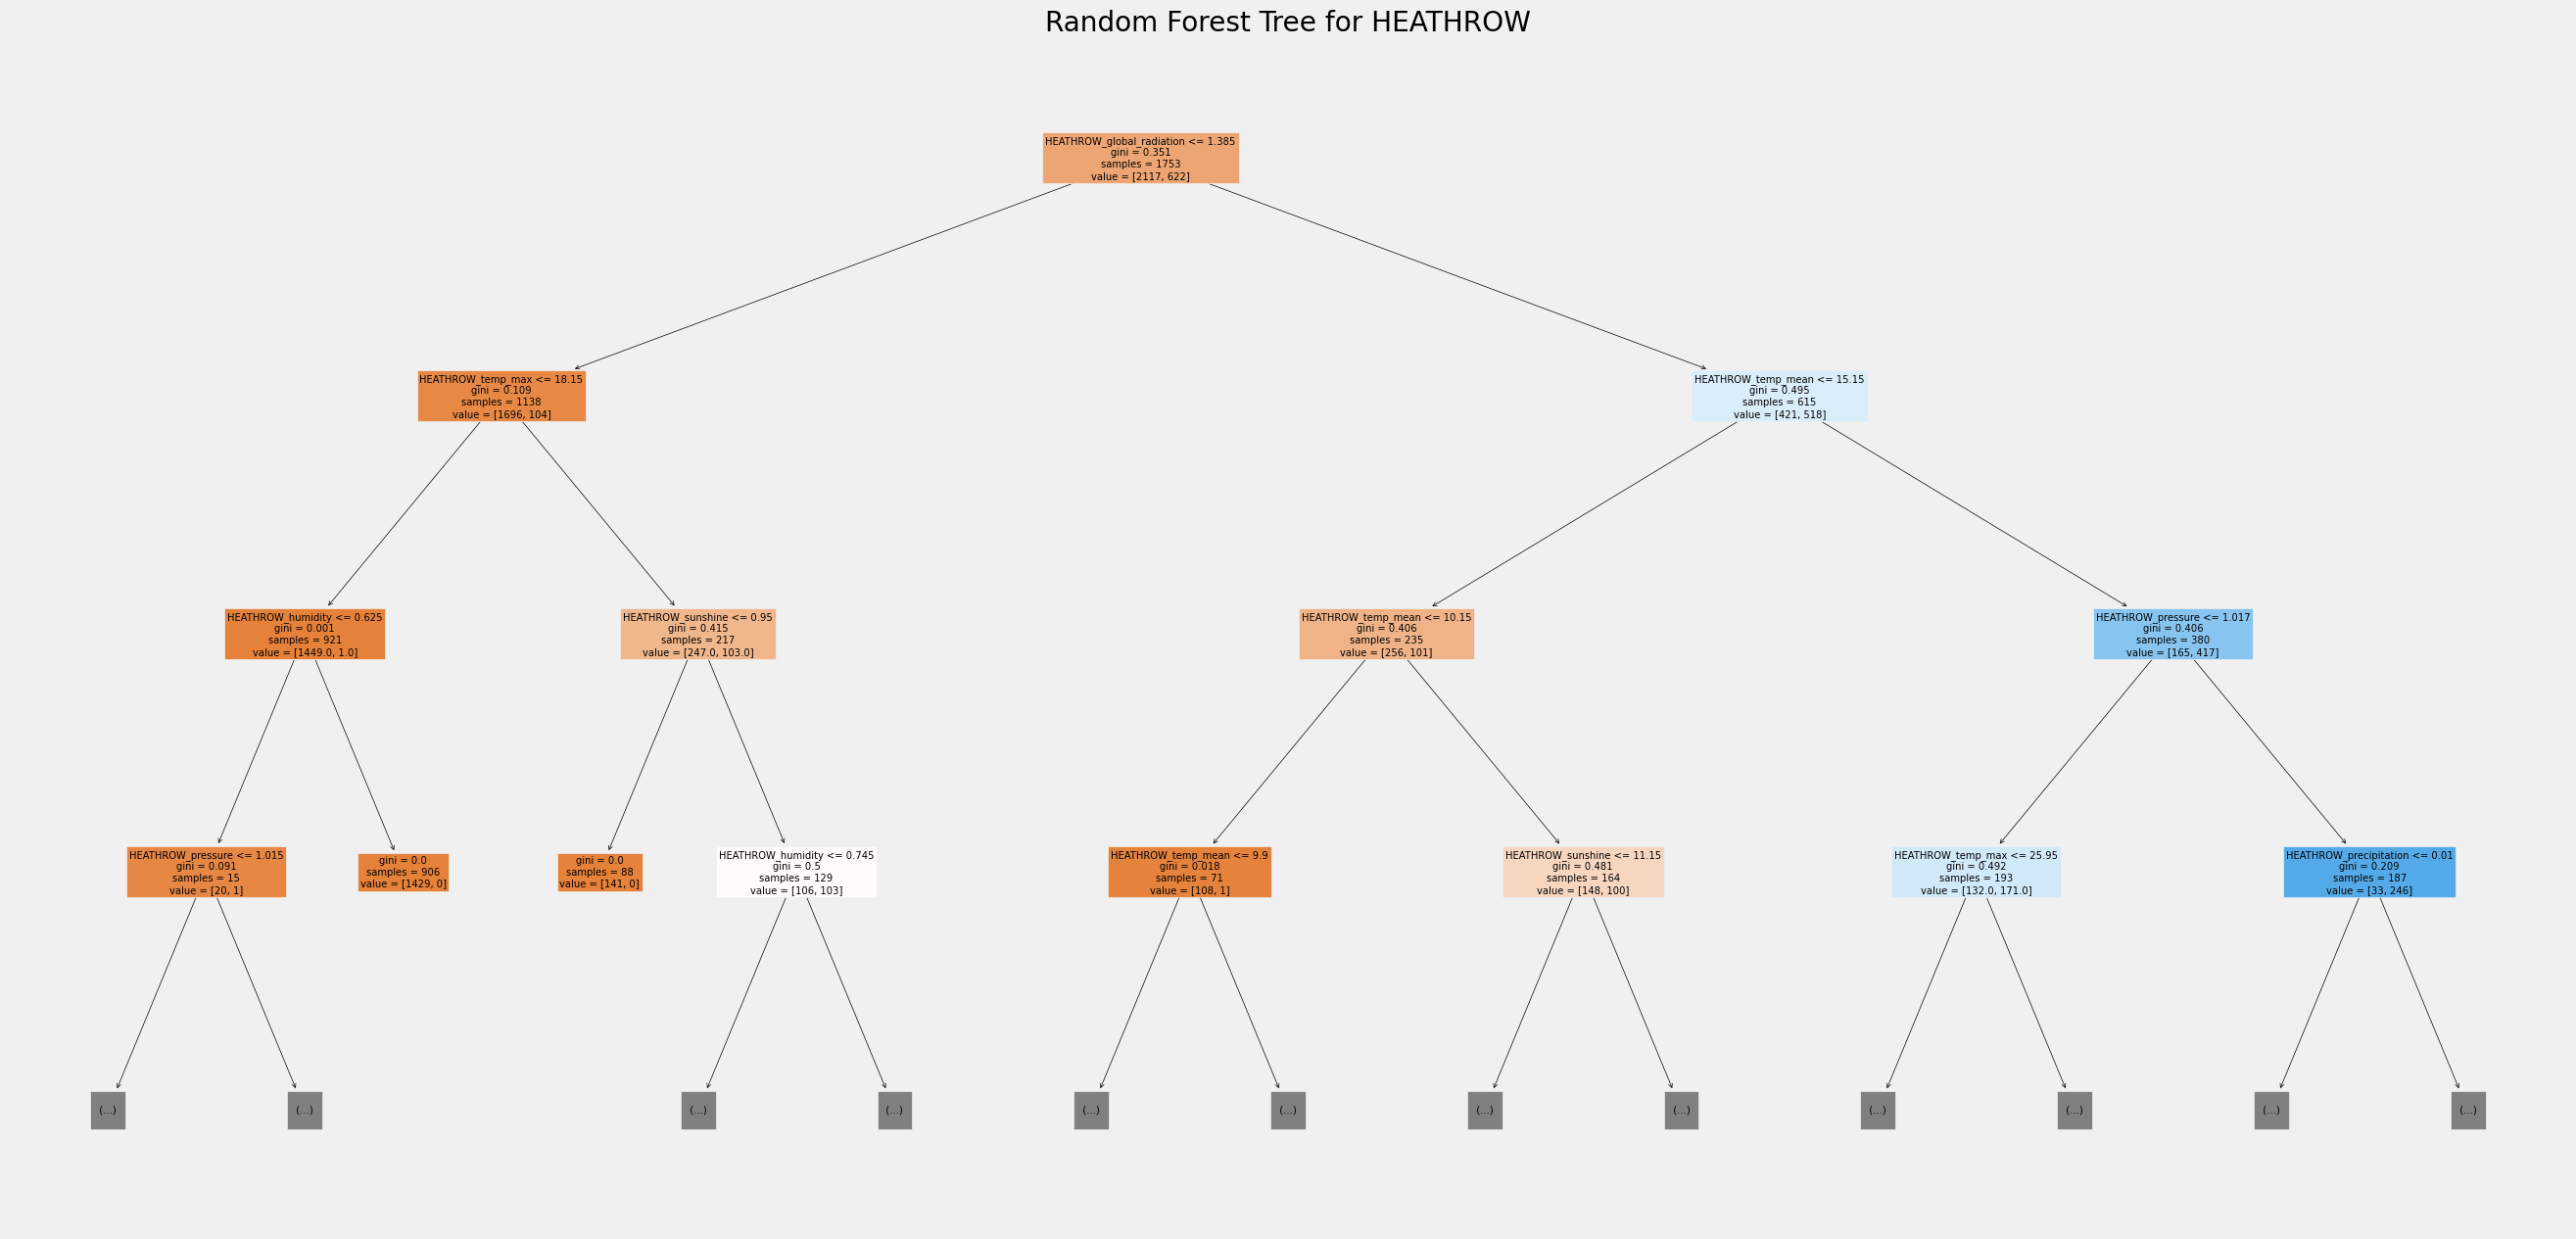

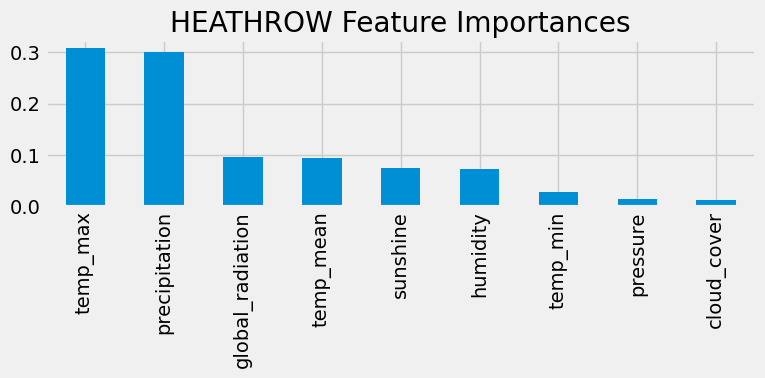

In [30]:
top_3_stations = ['BASEL','MAASTRICHT','HEATHROW']

for station in top_3_stations:
    # 1. Subset the original dfdecade_weather with station columns only
    station_cols = [col for col in dfdecade_weather.columns if col.startswith(station)]
    df_station = dfdecade_weather[station_cols].copy()

    # 2. Subset answers for that station
    station_answer_col = station + "_pleasant_weather"
    df_station_answers = dfdecade_answers[station_answer_col].copy()

    # 3. Convert to arrays
    X_station = df_station.values
    y_station = df_station_answers.values

    # 4. Train/test split
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X_station, y_station, random_state=42
    )

    # 5. Fit model
    clf_s = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_s.fit(X_train_s, y_train_s)

    # Evaluate
    y_pred_s = clf_s.predict(X_test_s)
    acc_s = metrics.accuracy_score(y_test_s, y_pred_s)

    print(f"Model for {station} Accuracy:", acc_s)

    # 6. Plot one of the trees
    fig_s = plt.figure(figsize=(30, 15))
    plot_tree(clf_s.estimators_[0], 
              feature_names=station_cols,
              filled=True,
              max_depth=3)
    plt.title(f"Random Forest Tree for {station}")
    plt.show()

    # 7. Feature importances
    feat_importances_s = clf_s.feature_importances_
    # Convert to Series for plotting:
    station_features = [c.replace(station + "_","") for c in station_cols]
    station_import_series = pd.Series(feat_importances_s, index=station_features)

    station_import_series.sort_values(ascending=False).plot.bar(
        figsize=(8,4), title=f"{station} Feature Importances"
    )
    plt.tight_layout()
    plt.show()
